# Benchmark de modelos preentrenados para clasificación

En este trabajo comparamos cuatro modelos preentrenados populares: **ResNet18** (nuestro baseline), **EfficientNet_B0**, **MobileNet_V3_Large** y **ConvNeXt_Tiny**.

En el caso del **ResNet18**, descongelamos las últimas **tres capas** del backbone para que puedan ajustarse durante el entrenamiento. Para los otros tres modelos, solo descongelamos la **última capa**.

Luego, reemplazamos esa capa descongelada por una identidad (`nn.Identity()`), lo que permite conectar un clasificador personalizado compuesto por capas lineales, activaciones y dropout que realiza la clasificación final.

En resumen, el flujo es:

**backbone (capas descongeladas entrenables) → capa identidad → clasificador personalizado**.

Este método aprovecha el aprendizaje transferido del backbone mientras ajusta la salida para nuestras clases específicas.

Para la optimización, consideramos tres valores diferentes de learning rate como principal hiperparámetro a ajustar, dado que los recursos y tiempo disponibles limitan la exploración de otros ajustes.

----------------

La elección de estas arquitecturas se basa en el trabajo *EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks* ([Paper en arXiv](https://arxiv.org/pdf/1905.11946)), así como en el análisis presentado en este [artículo](https://research.google/blog/efficientnet-improving-accuracy-and-efficiency-through-automl-and-model-scaling/). En particular, se seleccionó el modelo **EfficientNet_B0** (utilizado como baseline en dicho estudio) por mostrar un desempeño superior al **ResNet32**, como se ilustra en la siguiente figura (Figura 1 del paper).

Además, se incorporaron los modelos **MobileNet_V3_Large** y **ConvNeXt_Tiny** para ampliar la comparación. MobileNet_V3 también presenta buen desempeño usando *compound scaling* (método desarrollado para balancear profundidad, ancho y resolución de la red de manera eficiente), mientras que ConvNeXt_Tiny es una arquitectura moderna, eficiente y competitiva que no aparece en el estudio original.

Dado el método desarrollado en el estudio de EfficientNet y basado en la mejora de performance lograda mediante *compound scaling* (ver el paper para más detalles), en etapas posteriores se planea extender el análisis a modelos **EfficientNet** más avanzados, como los **B1**, **B2**, y sucesivos.


<img src="https://1.bp.blogspot.com/-oNSfIOzO8ko/XO3BtHnUx0I/AAAAAAAAEKk/rJ2tHovGkzsyZnCbwVad-Q3ZBnwQmCFsgCEwYBhgL/s1600/image3.png" alt="Descripción" height="400">

In [1]:
# Recomendado por PyTorch Lightning para aprovechar Tensor Cores (por la arquitectura de mi GPU)
import torch
torch.set_float32_matmul_precision('medium')

import shutil

# Borrar checkpoints anteriores
# shutil.rmtree("checkpoints", ignore_errors=True)

# Borrar logs anteriores
#shutil.rmtree("lightning_logs", ignore_errors=True)

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Cargar los tensores guardados
X_train, y_train = torch.load("train_normalizado.pt")
X_val, y_val = torch.load("val_normalizado.pt")
X_test, y_test = torch.load("test_normalizado.pt")

# Crear datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Crear loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=False)
val_loader   = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=False)
test_loader  = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=False)

In [3]:
import torch
import torch.nn as nn
from lightning import LightningModule, Trainer
from lightning.pytorch.loggers import CSVLogger
from torchvision import models
import os

def get_in_features(base_model):
    base_model.eval()
    with torch.no_grad():
        dummy = torch.randn(1, 3, 224, 224).to(next(base_model.parameters()).device)
        out = base_model(dummy)
    return out.shape[1]

class LitClassifier(LightningModule):
    def __init__(self, base_model_fn, weights, freeze_layer_name, num_classes=3, lr=3e-5):
        super().__init__()
        self.save_hyperparameters()
        base_model = base_model_fn(weights=weights)
        for name, param in base_model.named_parameters():
            if freeze_layer_name not in name:
                param.requires_grad = False
        if hasattr(base_model, "fc"):
            base_model.fc = nn.Identity()
            in_features = get_in_features(base_model)
        elif hasattr(base_model, "classifier"):
            if isinstance(base_model.classifier, nn.Sequential):
                base_model.classifier = nn.Identity()
                in_features = get_in_features(base_model)
            else:
                base_model.classifier = nn.Identity()
                in_features = get_in_features(base_model)
        self.model = nn.Sequential(
            base_model,
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, _):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, _):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


def train_and_test_models(train_loader, val_loader, test_loader):
    model_defs = [
        (models.resnet18, models.ResNet18_Weights.DEFAULT, "layer3"),
        (models.efficientnet_b0, models.EfficientNet_B0_Weights.DEFAULT, "features.8"),
        (models.mobilenet_v3_large, models.MobileNet_V3_Large_Weights.DEFAULT, "features.8"),
        (models.convnext_tiny, models.ConvNeXt_Tiny_Weights.DEFAULT, "features.7"),
    ]

    learning_rates = [1e-4, 3e-5, 1e-5]

    os.makedirs("checkpoints", exist_ok=True)
    results = {}
    history = {}

    for lr in learning_rates:
        for fn, w, freeze_name in model_defs:
            name = fn.__name__
            print(f"Entrenando {name} con lr={lr}: congelando todo menos {freeze_name}")
            logger = CSVLogger("lightning_logs", name=f"{name}_lr{lr}")
            model = LitClassifier(fn, w, freeze_name, num_classes=3, lr=lr)
            trainer = Trainer(
                max_epochs=40,
                accelerator="gpu" if torch.cuda.is_available() else "cpu",
                logger=logger
            )
            trainer.fit(model, train_loader, val_loader)

            checkpoint_path = f"checkpoints/{name}_lr{lr}_final.ckpt"
            trainer.save_checkpoint(checkpoint_path)

            metrics_df = logger.experiment.metrics
            history[f"{name}_lr{lr}"] = metrics_df

            model.eval()
            all_preds, all_labels = [], []
            for x, y in test_loader:
                x = x.to(model.device)
                with torch.no_grad():
                    preds = model(x).argmax(1)
                    all_preds.append(preds.cpu())
                    all_labels.append(y)
            results[f"{name}_lr{lr}"] = {
                "preds": torch.cat(all_preds),
                "labels": torch.cat(all_labels)
            }

    return results, history

In [4]:
# Descomentar para ejecutar el entrenamiento
# results, history = train_and_test_models(train_loader, val_loader, test_loader)

In [5]:
# Guardar resultados y métricas
import pickle

#torch.save(results, "results.pt")
#torch.save(history, "history.pt")
results = torch.load("results.pt")
history = torch.load("history.pt")

A continuación se muestran la pérdida (**loss**) tanto en entrenamiento como en validación, y la precisión (**accuracy**), todas en función de las épocas. Con esto se puede inferir si los modelos generalizan bien y si existe sobreajuste.

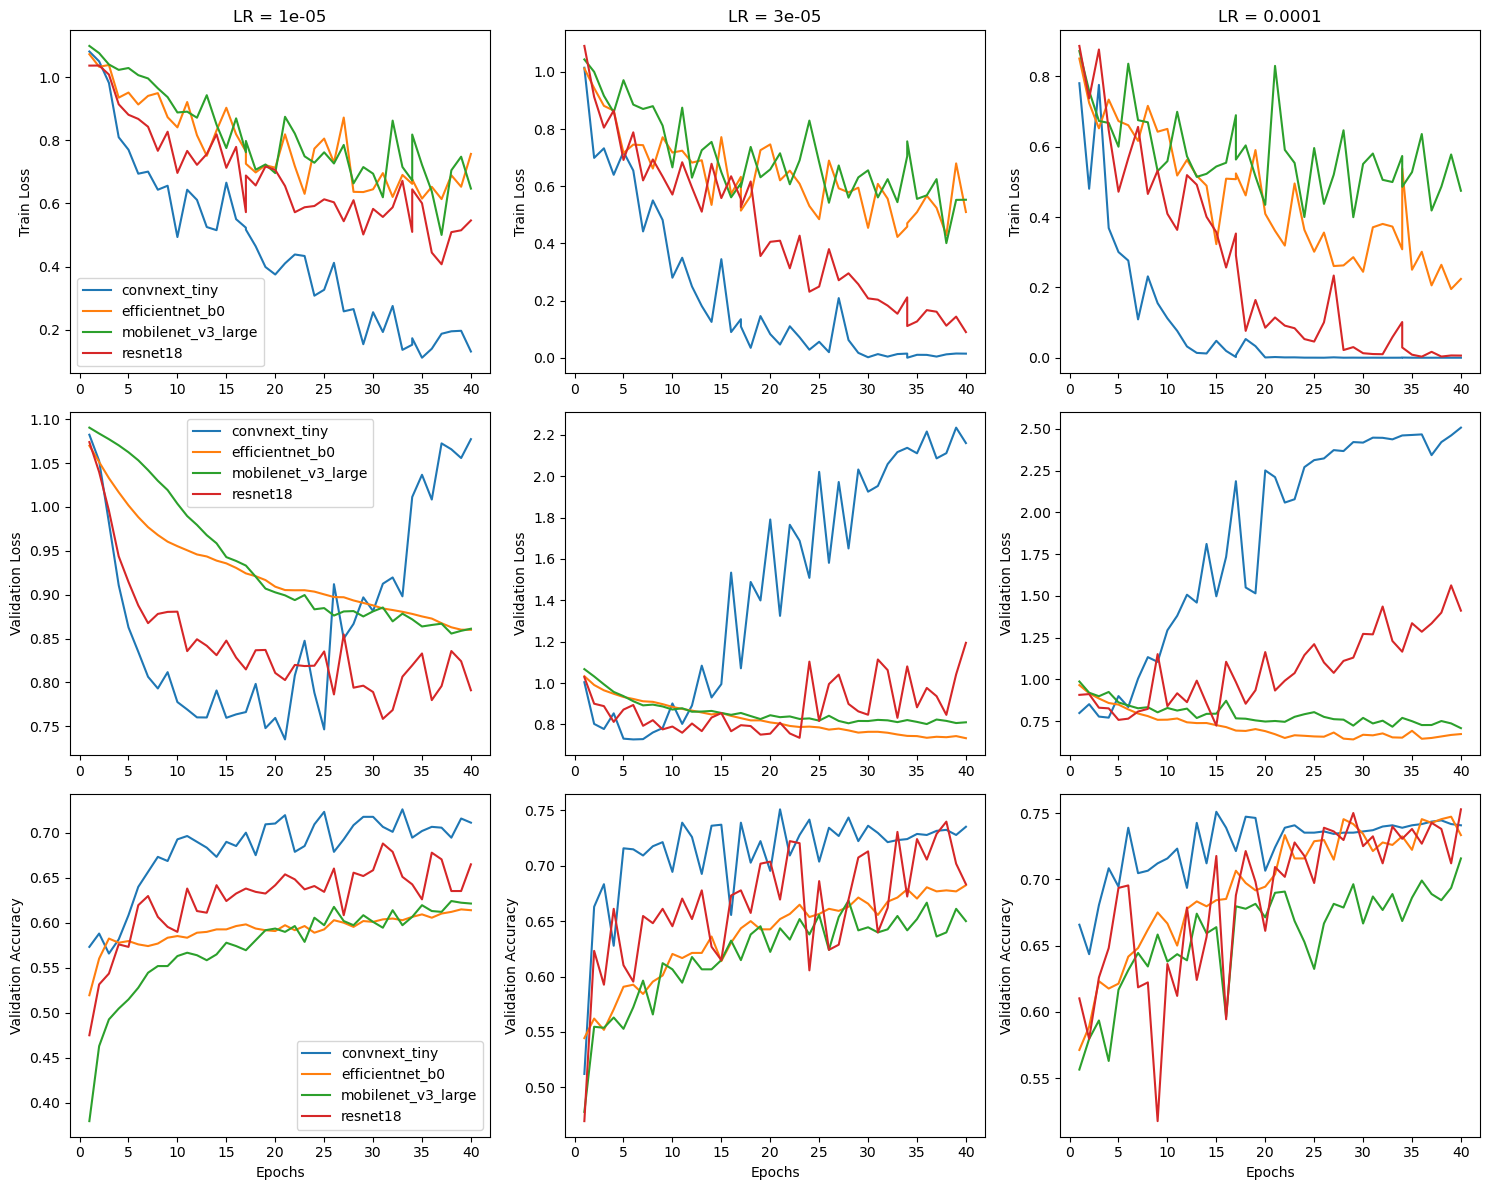

In [ ]:
import matplotlib.pyplot as plt

def load_history_from_logs(log_root="lightning_logs"):
    history = {}
    for folder in os.listdir(log_root):
        folder_path = os.path.join(log_root, folder)
        if not os.path.isdir(folder_path):
            continue
        version_path = os.path.join(folder_path, "version_0", "metrics.csv")
        if os.path.exists(version_path):
            df = pd.read_csv(version_path)
            history[folder] = df
    return history

history = load_history_from_logs()

lrs = sorted({float(k.split("_lr")[1]) for k in history.keys()})
modelos = sorted({k.split("_lr")[0] for k in history.keys()})

fig, axes = plt.subplots(3, len(lrs), figsize=(5*len(lrs), 12), sharex=False)

for col, lr in enumerate(lrs):
    for modelo in modelos:
        if "feature" in modelo:
            continue

        key = f"{modelo}_lr{lr}"
        if key not in history:
            continue

        df = history[key]

        train_loss_df = df.dropna(subset=['train_loss'])
        epochs_train = train_loss_df['epoch'] + 1
        train_loss = train_loss_df['train_loss']

        val_df = df.dropna(subset=['val_loss', 'val_acc'])
        epochs_val = val_df['epoch'] + 1
        val_loss = val_df['val_loss']
        val_acc = val_df['val_acc']

        axes[0, col].plot(epochs_train, train_loss, linestyle='-', label=f"{modelo}")
        axes[1, col].plot(epochs_val, val_loss, linestyle='-', label=f"{modelo}")
        axes[2, col].plot(epochs_val, val_acc, linestyle='-', label=f"{modelo}")

    axes[0, col].set_title(f"LR = {lr}")
    axes[0, col].set_ylabel("Train Loss")
    axes[1, col].set_ylabel("Validation Loss")
    axes[2, col].set_ylabel("Validation Accuracy")
    axes[2, col].set_xlabel("Epochs")

for row in range(3):
    axes[row, 0].legend(loc='best')

plt.tight_layout()
plt.show()

## Comparación de modelos con matrices de confusión

A continuación se muestran las matrices de **confusión** para los cuatro modelos, tanto en forma **nominal** como **normalizada**. Se considera el mayor **learning rate** utilizado, ya que es el que ofrece mejores resultados en términos generales, tal como se mostrará al comparar **recall**, **F1** y un **puntaje personalizado**.

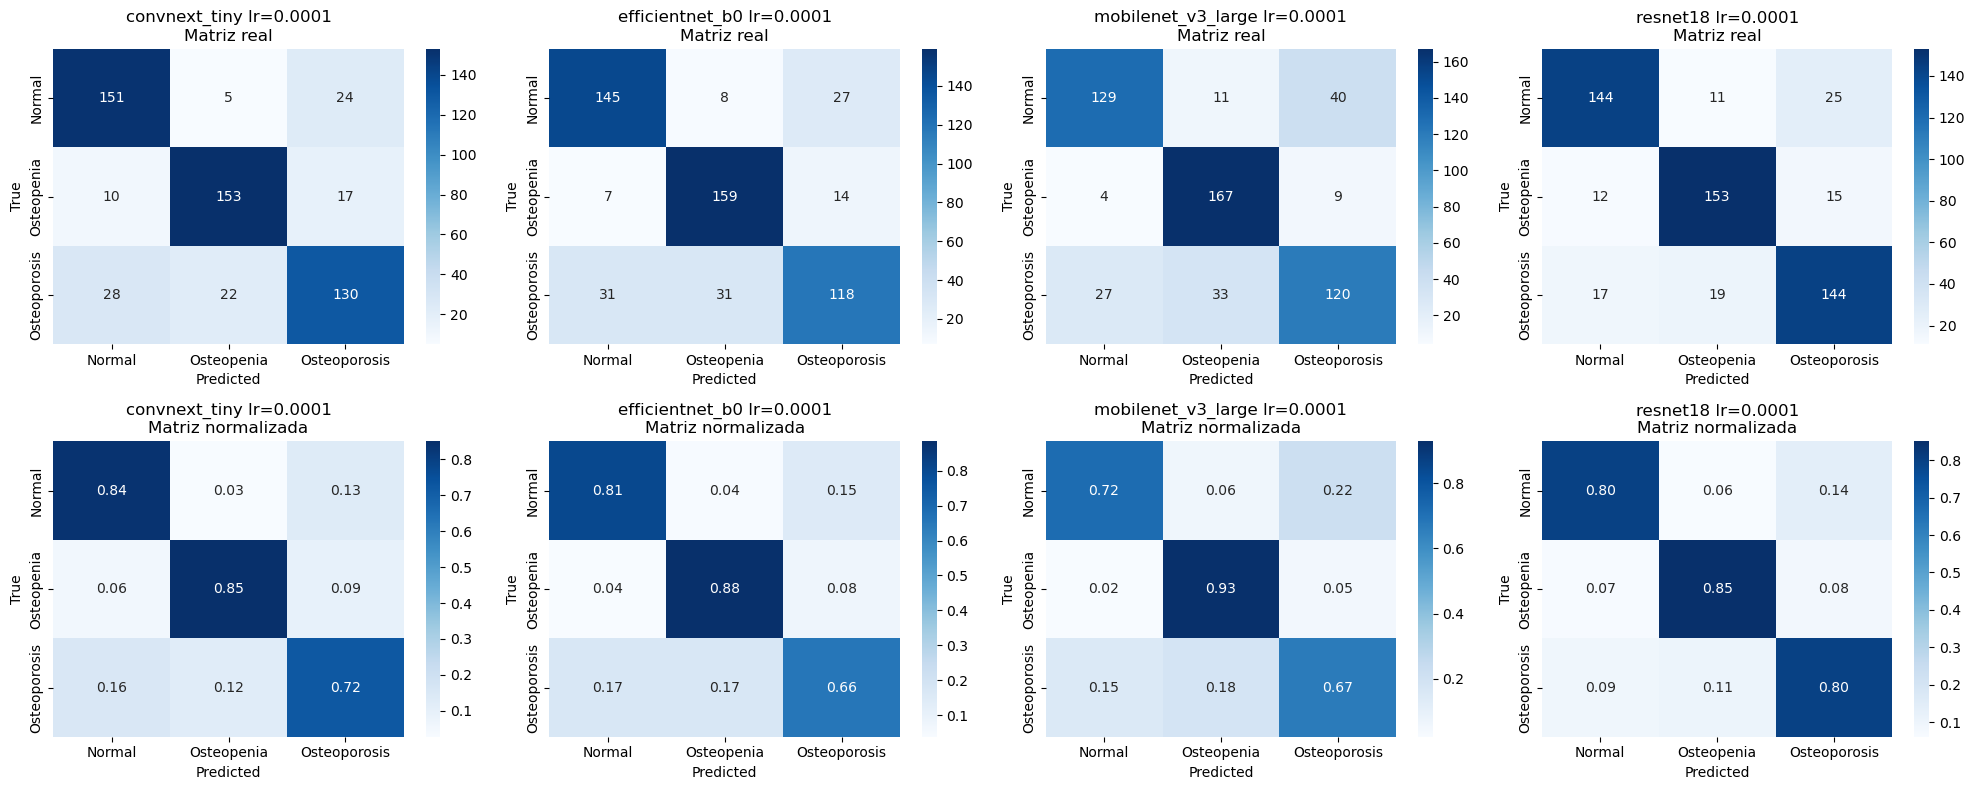

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

lr_target = 1e-4
model_names = sorted({k.split("_lr")[0] for k in results.keys()})

fig, axes = plt.subplots(2, len(model_names), figsize=(5 * len(model_names), 8))

for i, modelo in enumerate(model_names):
    key = f"{modelo}_lr{lr_target}"
    if key not in results:
        print(f"No hay resultados para {key}")
        continue

    y_true = results[key]["labels"].numpy()
    y_pred = results[key]["preds"].numpy()

    # Matriz real
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, i],
                xticklabels=['Normal', 'Osteopenia', 'Osteoporosis'],
                yticklabels=['Normal', 'Osteopenia', 'Osteoporosis'])
    axes[0, i].set_title(f"{modelo} lr={lr_target}\nMatriz real")
    axes[0, i].set_xlabel("Predicted")
    axes[0, i].set_ylabel("True")

    # Matriz normalizada por fila
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", ax=axes[1, i],
                xticklabels=['Normal', 'Osteopenia', 'Osteoporosis'],
                yticklabels=['Normal', 'Osteopenia', 'Osteoporosis'])
    axes[1, i].set_title(f"{modelo} lr={lr_target}\nMatriz normalizada")
    axes[1, i].set_xlabel("Predicted")
    axes[1, i].set_ylabel("True")

plt.tight_layout()
plt.show()


## Métricas adicionales

- **Recall enfermo vs sano:** mide qué tan bien el modelo detecta a los pacientes enfermos (osteopenia u osteoporosis) sin confundirlos con sanos. No distingue entre tipos de enfermedad, solo sano vs enfermo.

- **F1 entre enfermedades:** evalúa el equilibrio entre precisión y recall al clasificar las distintas enfermedades, solo considerando pacientes enfermos. Esta métrica distingue entre osteopenia y osteoporosis.

- **Puntaje diagnóstico:** combinación ponderada del recall general y el F1 específico para enfermedades, para evaluar globalmente el desempeño clínico.


In [8]:
from sklearn.metrics import recall_score, f1_score

# Defino las métricas

def compute_enfermo_vs_sano_recall(y_true, y_pred):
    # Convertir a binario: 0 = Normal, 1 = Enfermo (Osteopenia u Osteoporosis)
    y_true_bin = [0 if x == 0 else 1 for x in y_true]
    y_pred_bin = [0 if x == 0 else 1 for x in y_pred]
    return recall_score(y_true_bin, y_pred_bin)

def compute_enfermedades_f1(y_true, y_pred):
    # Filtro solo los casos enfermos
    y_true_sub = [x for x in y_true if x != 0]
    y_pred_sub = [p for x, p in zip(y_true, y_pred) if x != 0]
    return f1_score(y_true_sub, y_pred_sub, average='macro') 

def diagnostic_score(y_true, y_pred, alpha=0.7, beta=0.3):
    recall = compute_enfermo_vs_sano_recall(y_true, y_pred)
    f1_enf = compute_enfermedades_f1(y_true, y_pred)
    # Combino recall y f1 con pesos alpha y beta
    return alpha * recall + beta * f1_enf

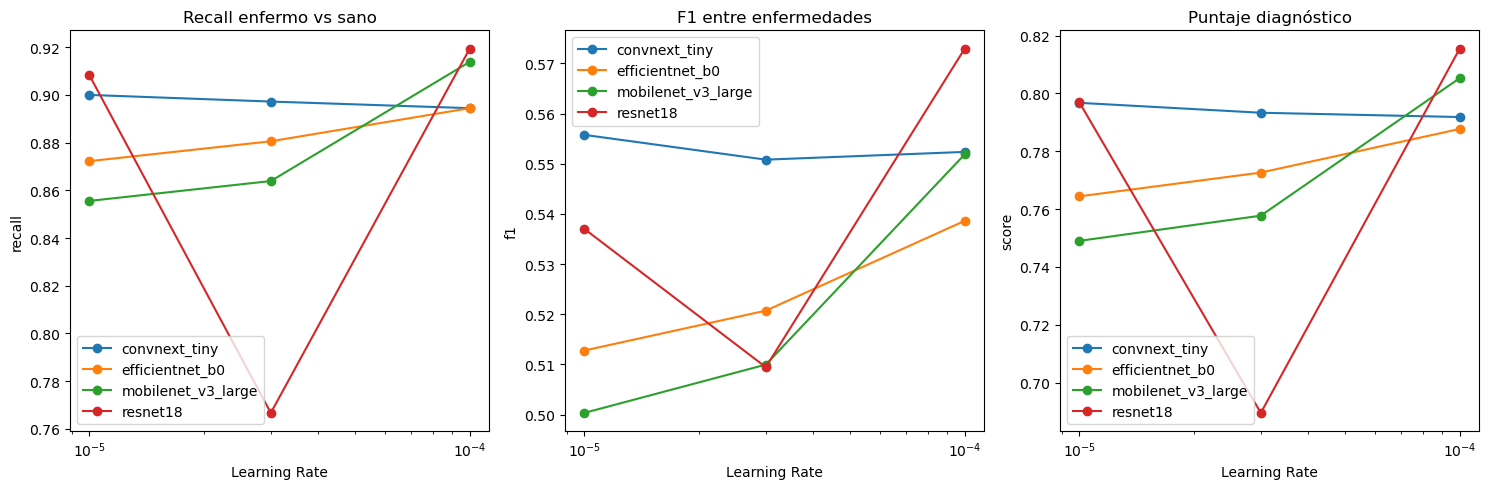

In [33]:
import pandas as pd

# Guardar métricas en lista
data = []
for key, vals in results.items():
    model_name, lr_str = key.split("_lr")
    lr = float(lr_str)
    
    y_true = vals["labels"].numpy()
    y_pred = vals["preds"].numpy()
    
    recall = compute_enfermo_vs_sano_recall(y_true, y_pred)
    f1 = compute_enfermedades_f1(y_true, y_pred)
    score = diagnostic_score(y_true, y_pred)
    
    data.append({
        "modelo": model_name,
        "lr": lr,
        "recall": recall,
        "f1": f1,
        "score": score
    })

df = pd.DataFrame(data)
df = df.sort_values(by=["lr", "modelo"])

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

metricas = ["recall", "f1", "score"]
titulos = ["Recall enfermo vs sano", "F1 entre enfermedades", "Puntaje diagnóstico"]

for ax, metrica, titulo in zip(axes, metricas, titulos):
    for modelo, subdf in df.groupby("modelo"):
        ax.plot(subdf["lr"], subdf[metrica], marker="o", label=modelo)
    ax.set_title(titulo)
    ax.set_xlabel("Learning Rate")
    ax.set_ylabel(metrica)
    ax.set_xscale("log")  
    ax.legend()

plt.tight_layout()
plt.show()


Basado en las tres métricas, el mejor modelo es el **ResNet18**. Este modelo es el más sensible al learning rate elegido, tal como se muestra en los gráficos. En particular, con un learning rate de 1e-4 se obtienen los mejores resultados, pero con el valor intermedio de 3e-5 se consiguen los peores resultados (salvo en el F1).

También se observa que, en **EfficientNet_B0** y **MobileNet_V3_Large**, a medida que aumentamos el learning rate (para los tres valores utilizados), las métricas mejoran. En cambio, para el **ConvNeXt_Tiny** ocurre lo opuesto.

Es importante notar que el modelo con más capas entrenadas (descongeladas) fue el **ResNet18**. Esto podría explicar, en términos generales, por qué obtiene mejores resultados. En particular, la cantidad de capas descongeladas es:

- **ResNet18:** `layer3` (últimas 3 capas del backbone descongeladas + modelo secuencial).
- **EfficientNet_B0:** `features.8` (última capa del backbone descongelada + modelo secuencial).
- **MobileNet_V3_Large:** `features.8` (última capa del backbone descongelada + modelo secuencial).
- **ConvNeXt_Tiny:** `features.7` (última capa del backbone descongelada + modelo secuencial).

Sería conveniente entrenar los modelos descongelando más capas. Además, se podrían considerar otros modelos. Dado que se vio que el mayor learning rate es el que da mejores resultados en 3 de los 4 modelos, será el que se utilice para futuros entrenamientos.

## Nuevos modelos

Pruebo ahora el **EfficientNet_B0** y el **MobilNet_V3_Large** con las dos últimas capas descongeladas. Además, considero el **EfficientNet_B3** con la última capa descongelada. Comparo estos tres modelos con el baseline, es decir, el **ResNet18** con las ultimas 3 capas descongeladas. 
Dado que el mejor resultado en las métricas utilizadas para comparar las predicciones fue con el **leraning rate** de 1e-4, es el único que utilizo en el siguiente análisis.

In [10]:
def train_and_test_new_models(train_loader, val_loader, test_loader):
    model_defs = [
        (models.efficientnet_b3, models.EfficientNet_B3_Weights.DEFAULT, "features.7"),
        (models.mobilenet_v3_large, models.MobileNet_V3_Large_Weights.DEFAULT, "features.6"),
        (models.efficientnet_b0, models.EfficientNet_B0_Weights.DEFAULT, "features.7"),
        (models.efficientnet_b0, models.EfficientNet_B0_Weights.DEFAULT, "features.6"),
    ]

    learning_rates = [1e-4]

    os.makedirs("checkpoints", exist_ok=True)
    results = {}
    history = {}

    for lr in learning_rates:
        for fn, w, freeze_name in model_defs:
            name = f"{fn.__name__}_uf_{freeze_name.replace('.', '-')}"
            print(f"Entrenando {name} con lr={lr}: congelando todo menos {freeze_name}")
            logger = CSVLogger("lightning_logs", name=f"{name}_lr{lr}")
            model = LitClassifier(fn, w, freeze_name, num_classes=3, lr=lr)
            trainer = Trainer(
                max_epochs=40,
                accelerator="gpu" if torch.cuda.is_available() else "cpu",
                logger=logger
            )
            trainer.fit(model, train_loader, val_loader)

            checkpoint_path = f"checkpoints/{name}_lr{lr}_final.ckpt"
            trainer.save_checkpoint(checkpoint_path)

            metrics_df = logger.experiment.metrics
            history[f"{name}_lr{lr}"] = metrics_df

            model.eval()
            all_preds, all_labels = [], []
            for x, y in test_loader:
                x = x.to(model.device)
                with torch.no_grad():
                    preds = model(x).argmax(1)
                    all_preds.append(preds.cpu())
                    all_labels.append(y)
            results[f"{name}_lr{lr}"] = {
                "preds": torch.cat(all_preds),
                "labels": torch.cat(all_labels)
            }

    return results, history

In [11]:
#new_results, new_history = train_and_test_new_models(train_loader, val_loader, test_loader)

#torch.save(new_results, "new_results.pt")
#torch.save(new_history, "new_history.pt")

In [12]:
new_results = torch.load("new_results.pt")
new_history = torch.load("new_history.pt")

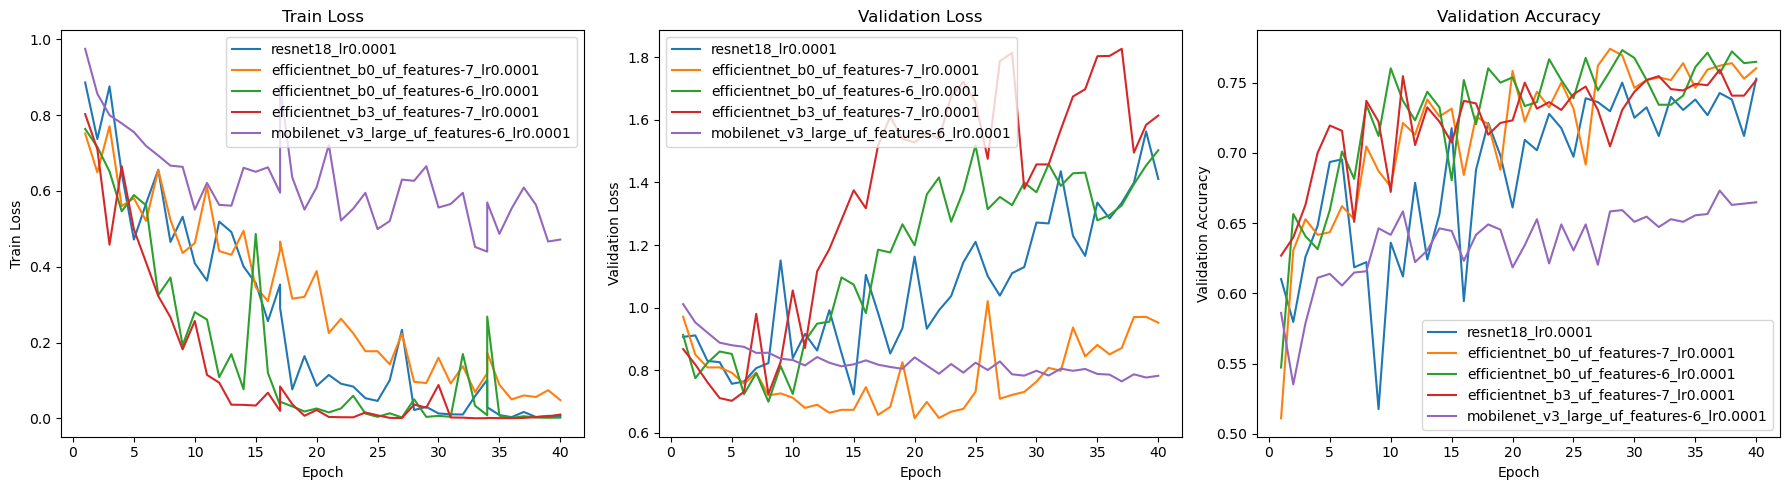

In [31]:
model_folders = [
    "resnet18_lr0.0001",
    "efficientnet_b0_uf_features-7_lr0.0001",
    "efficientnet_b0_uf_features-6_lr0.0001",
    "efficientnet_b3_uf_features-7_lr0.0001",
    "mobilenet_v3_large_uf_features-6_lr0.0001"
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 fila, 3 columnas

for model in model_folders:
    if model not in history:
        print(f"No encontrado: {model}")
        continue
    
    df = history[model]
    epochs_train = df.dropna(subset=['train_loss'])['epoch'] + 1
    train_loss = df.dropna(subset=['train_loss'])['train_loss']
    val_df = df.dropna(subset=['val_loss', 'val_acc'])
    epochs_val = val_df['epoch'] + 1
    val_loss = val_df['val_loss']
    val_acc = val_df['val_acc']
    
    axes[0].plot(epochs_train, train_loss, label=model)
    axes[1].plot(epochs_val, val_loss, label=model)
    axes[2].plot(epochs_val, val_acc, label=model)

axes[0].set_title("Train Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Train Loss")

axes[1].set_title("Validation Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Validation Loss")

axes[2].set_title("Validation Accuracy")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Validation Accuracy")

for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

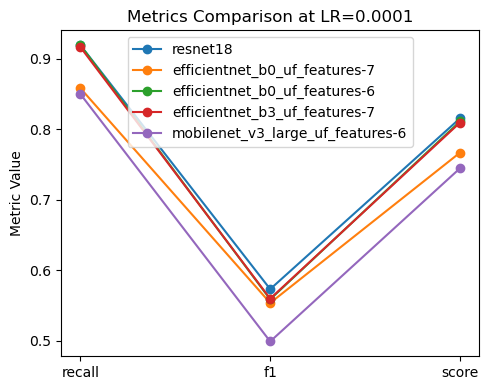

In [42]:
data = []

for key, vals in results.items():
    model_name, lr_str = key.split("_lr")
    if model_name != "resnet18":
        continue
    lr = float(lr_str)
    y_true = vals["labels"].numpy()
    y_pred = vals["preds"].numpy()
    recall = compute_enfermo_vs_sano_recall(y_true, y_pred)
    f1 = compute_enfermedades_f1(y_true, y_pred)
    score = diagnostic_score(y_true, y_pred)
    data.append({"modelo": model_name, "lr": lr, "recall": recall, "f1": f1, "score": score})

for key, vals in new_results.items():
    model_name, lr_str = key.split("_lr")
    if model_name == "resnet18":
        continue
    lr = float(lr_str)
    y_true = vals["labels"].numpy()
    y_pred = vals["preds"].numpy()
    recall = compute_enfermo_vs_sano_recall(y_true, y_pred)
    f1 = compute_enfermedades_f1(y_true, y_pred)
    score = diagnostic_score(y_true, y_pred)
    data.append({"modelo": model_name, "lr": lr, "recall": recall, "f1": f1, "score": score})

df = pd.DataFrame(data)
df_lr = df[df["lr"] == 0.0001]

metrics = ["recall", "f1", "score"]
x = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(5,4))

for model in model_folders:
    subdf = df_lr[df_lr["modelo"] == model]
    if subdf.empty:
        continue
    values = [subdf[metric].values[0] for metric in metrics]
    ax.plot(x, values, marker='o', label=model)

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel("Metric Value")
ax.set_title("Metrics Comparison at LR=0.0001")
ax.legend(loc='best')

plt.tight_layout()
plt.show()

No se observaron mejoras respecto al baseline al descongelar más capas ni al usar la versión **EfficientNet_B3**. Se evidenció sobreajuste durante los entrenamientos. Probablemente, sería conveniente implementar **early stopping** para mitigarlo.